In [1]:
from pyvela import SPNTA
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
spnta = SPNTA (
    parfile ="NGC6440E.par",
    timfile ="NGC6440E.tim",
)

In [3]:
nwalkers = spnta.ndim * 5
p0 = np.array([
    spnta.prior_transform(cube)
    for cube in np.random.rand(nwalkers, spnta.ndim)
])

In [4]:
spnta.lnpost_vectorized(p0)

40-element Vector{Float64}:
      -1.2820923856881682e6
      -2.9941532108381535e6
      -1.5930697984281878e6
      -2.7344745236783857e6
      -1.973564900645128e6
 -254186.5065395236
      -1.5285604451708656e6
 -100000.07803020386
      -5.697506397417646e6
 -724186.9347251018
       ⋮
      -1.6830189194755128e6
      -2.7350125209149914e6
      -1.7580770000766756e6
      -4.0440534262021612e6
 -386689.5174769667
 -207930.08629774093
 -422278.5758753168
  -42884.497264239195
      -1.3205875428824471e6

In [5]:
sampler = emcee.EnsembleSampler(
    nwalkers,
    spnta.ndim,
    spnta.lnpost,
)

In [6]:
sampler.run_mcmc(p0, 6000, progress=True);

100%|██████████████████████████████████████| 6000/6000 [00:17<00:00, 339.23it/s]


In [7]:
samples_raw = sampler.get_chain(flat=True, discard=1000, thin=50)
samples = spnta.rescale_samples(samples_raw)

In [8]:
F_ = spnta.model.param_handler._default_params_tuple.F_.x
shifts = np.array([0 if pname != "F0" else F_ for pname in spnta.param_names])

In [9]:
params_med_raw = np.median(samples_raw, axis=0)
params_med = spnta.rescale_samples(params_med_raw)
params_std = np.std(samples, axis=0)

print(f"Param\t{'Unit':<15}{'Value':<33}Units")
print("-" * 77)
for pname, punit, pval, pstd in zip(spnta.param_names, spnta.param_units, (params_med + shifts), params_std):
    print(f"{pname}\t{punit:<15}{pval}\t+/-\t{pstd}")

Param	Unit           Value                            Units
-----------------------------------------------------------------------------
RAJ	hourangle      17.81466676406106	+/-	3.910665738499523e-08
DECJ	deg            -20.35816194441771	+/-	9.70464286270825e-06
PHOFF	1              0.09837066379940249	+/-	0.0004571768570625641
DM	pc / cm3       224.1145351403524	+/-	0.0358730679865722
F0	Hz             61.48547655437103	+/-	1.9769554672229723e-11
F1	Hz / s         -1.1813488340541039e-15	+/-	1.5559724995630074e-18
EFAC1	1              1.0169239882426024	+/-	0.10402678198980696
EQUAD1	us             0.1896376550930416	+/-	4.59440755755371


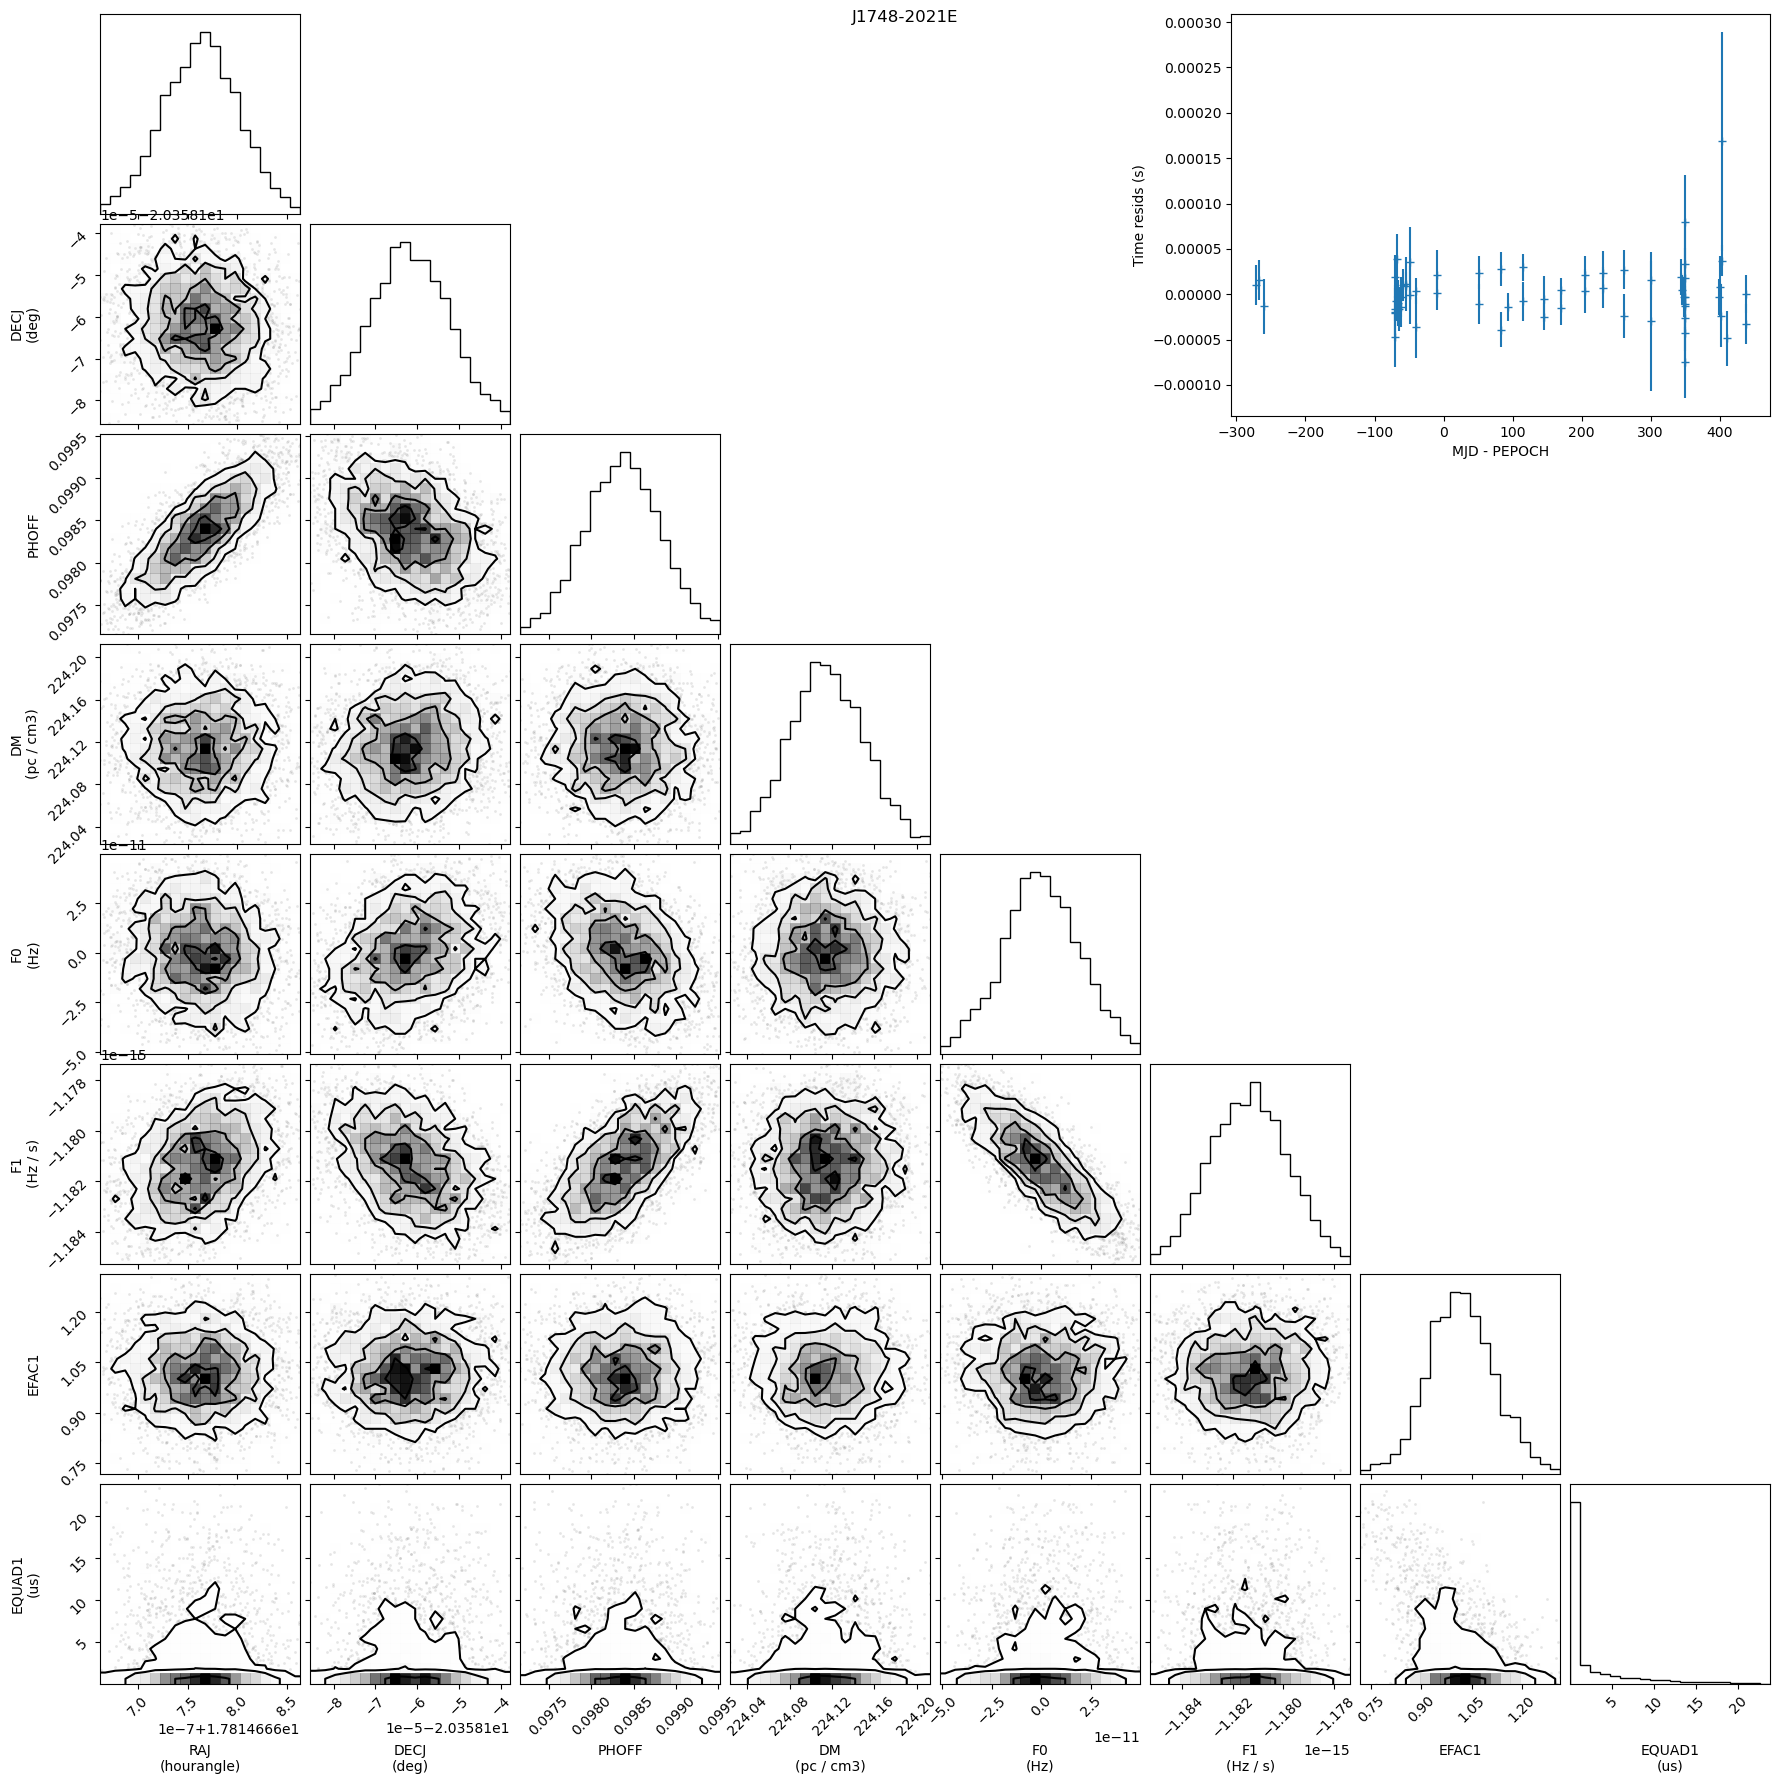

In [10]:
fig = corner.corner(
    samples,
    labels=spnta.param_labels,
    range=[0.99]*spnta.ndim
)

plt.subplot(433)
plt.errorbar(spnta.mjds, spnta.time_residuals(params_med_raw), spnta.scaled_toa_unceritainties(params_med_raw), ls="", marker="+")
plt.xlabel("MJD - PEPOCH")
plt.ylabel("Time resids (s)")

plt.suptitle(spnta.model.pulsar_name);

In [ ]:
# pyvela J0613-0200.InPTA.NB.par J0613-0200.InPTA.NB.tim -o J0613-0200.InPTA.NB_out -M -C 100 -f
# pyvela-plot J0613-0200.InPTA.NB_out